In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy as np
import pandas as pd

import tensorflow as tf
import keras

from collections import deque

from tqdm.notebook import tqdm

import gymnasium as gym
from gymnasium.utils.save_video import save_video


In [2]:

# Taken from: https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

In [3]:
# See https://gymnasium.farama.org/environments/box2d/lunar_lander/

# rng for the environment and to reshuffle samples
rng = np.random.default_rng(seed=34)

env = gym.make("ALE/Breakout-v5")
env.np_random = rng

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [4]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [5]:
STATE_SHAPE = env.observation_space.shape   # Dimension of the state array
N_ACTIONS = env.action_space.n              # Number of possible actions (0: do nothing, 1: fire, 2: right, 3: left)

N_EPISODES = 50              # Number of episodes to run for training 
MEMORY_BUFFER = 100_000         # Experience memory size  
BATCH_SIZE = 64                 # Batch size for neural network training 
UPDATE_STEP = 4                 # Number of steps to update target model

TAU =  0.05                    # Parameter for the soft update of the weights 
GAMMA = 0.995                    # Discount factor for the calculation of the return 

In [6]:
EPSILON_INTERVALS = [(200, .9), (400, .5), (600, .3), (1000, .1)]

def get_epsilon(episode):

    for l, e in EPSILON_INTERVALS:
        if episode <= l:
            return e
    return 0

In [7]:
# Network architecture:
#   Input: (210, 160, 3)
#   Padding: (1,2) -> (212, 164, 3)
#   Convolution: valid, f=5, s=1, 6 filters -> (208, 160, 6)
#   Maxpool: f=2, s=2 -> (104, 80, 6)
#   Convolution: valid, f=5, s=1, 16 filters -> (100, 76, 16)
#   Max pool: f=2, s=2 -> (50, 38, 16)
#   Convolution: valid, f=5, s=1, 32 filters - > (46, 34, 32)
#   Max pool: f=2, s=2 -> (23, 17, 32)
#   Flatten: 
#   Dense: -> 64
#   Dense: -> 4

def q_model():

    return keras.models.Sequential ([
            keras.layers.Input(shape=STATE_SHAPE),
            keras.layers.ZeroPadding2D(padding=(1,2)),
            keras.layers.Conv2D(6,(5, 5)),
            keras.layers.MaxPooling2D(4),
            keras.layers.Conv2D(16,(5, 5)),
            keras.layers.MaxPooling2D(2),
            keras.layers.Conv2D(32,(5, 5)),
            keras.layers.MaxPooling2D(2),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(4)
        ]) 

In [8]:
# Model used to select actions. Gets updated every batch
q_function = q_model()

# Model used to calculate the rewards for the future predictions that are used
# in the Bellman equation used as target for the updates of q_function. It is a different
# one for stability. Gets updated every UPDATE_STEP
q_function_target = q_model()
q_function_target.set_weights(q_function.get_weights())

loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

In [9]:
q_function.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 212, 164, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 208, 160, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 52, 40, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 36, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 14, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       143,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,388 (622.61 KB)

 Trainable params: 159,388 (622.61 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def get_samples(memory, sample_size):

  samples = random.sample(memory, sample_size)
  
  states, actions, states_next, rewards, terminated, truncated = zip(*samples)

  states = tf.convert_to_tensor(states, dtype='float32')
  actions = np.array(actions, dtype='int32')
  states_next = tf.convert_to_tensor(states_next, dtype='float32')
  rewards = np.array(rewards, dtype='float32')
  terminated = np.array(terminated, dtype='float32')

  return states, actions, states_next, rewards, terminated

In [11]:
# Train step

@tf.function
def train_step(samples, q_function, q_function_target):

  states, actions, states_next, rewards, terminated = samples

  # Use q_function_target to calculate Q(state_prime, action) used in Bellman equation
  max_qsa = tf.math.reduce_max(q_function_target(states_next, training=False), axis=1)

  # Bellman equation
  # For terminated states, q_value is just the reward
  qvalues_target = (rewards + (1 - terminated) * GAMMA * max_qsa)

  # Calculate mask so loss is calculated only on the action taken
  mask = tf.one_hot(actions, N_ACTIONS) 

  with tf.GradientTape() as tape:

    # Run model
    qvalues_predictions = tf.reduce_max(
      tf.multiply(q_function(states, training=True), mask), axis=1)

    # Calculate loss
    loss = loss_function(qvalues_target, qvalues_predictions)

  # Back propagation
  grads = tape.gradient(loss, q_function.trainable_variables)
  optimizer.apply_gradients(zip(grads, q_function.trainable_variables))

  return loss


In [12]:

memory = deque(maxlen=MEMORY_BUFFER) 
loss_hist = []
reward_hist = []
duration_hist = []
step = 0                # Step counter
episode = 0             # Episode counter
episode_reward = 0      # To accumulate the rewards of the episode
episode_duration = 0    # To keep a step count for the episode

state, _ = env.reset()
epsilon = get_epsilon(episode)

pbar = tqdm(desc="Episode", total=N_EPISODES)
while episode < N_EPISODES:

    # take action using e-greedy selection
    if rng.choice([True, False], p=[epsilon, 1 - epsilon]): 
        action = rng.choice(N_ACTIONS)
    else:
        # Use Q function to select next action
        state_tensor = tf.convert_to_tensor(state, dtype='float32')
        state_tensor = tf.expand_dims(state_tensor, 0)
        qvalue_predictions = q_function(state_tensor, training=False)

        action = np.argmax(qvalue_predictions[0])

    state_next, reward, terminated, truncated, _ = env.step(action)

    memory.append((state, action, state_next, reward, terminated, truncated))

    update = (step + 1 >= BATCH_SIZE) and not ((step + 1) % UPDATE_STEP)
    if update:
        #
        # Update q-function
        #

        samples = get_samples(memory, BATCH_SIZE)

        # Train network
        loss = train_step(samples, q_function, q_function_target)
        
        loss_hist.append(loss)

        # Update target model
        new_weights = []
        for new_w, old_w in zip(q_function.get_weights(), q_function_target.get_weights()):
            new_weights.append(TAU * new_w + (1 - TAU) * old_w)

        q_function_target.set_weights(new_weights)

    step += 1
    episode_duration += 1
    episode_reward += reward
    if terminated or truncated:
        # Experiment ended, reset the environment
        state, _ = env.reset()

        episode += 1
        reward_hist.append(episode_reward)
        duration_hist.append(episode_duration)
        episode_reward = 0
        episode_duration = 0
        epsilon = get_epsilon(episode)
        pbar.update(1)
    else:
        state = state_next

pbar.close()

Episode:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
loss_df = pd.Series(loss_hist)
loss_df.rolling(window=500).mean().plot()

array([[<Axes: >, <Axes: >]], dtype=object)

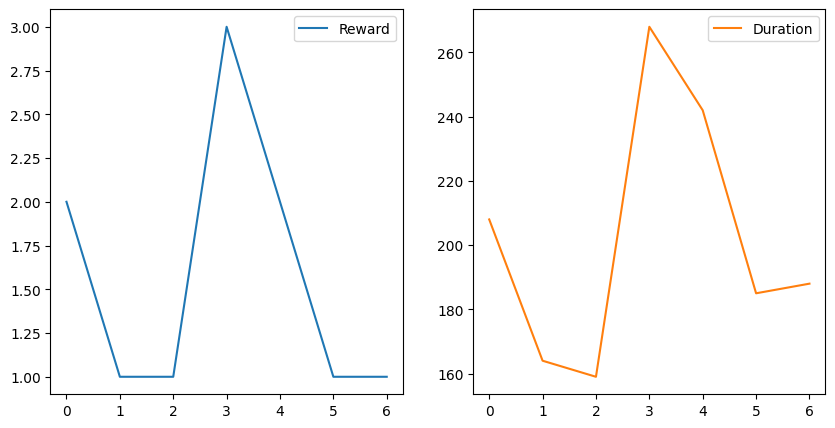

In [13]:

df_episodes = pd.DataFrame({
    "Reward": reward_hist,
    "Duration": duration_hist
    })
df_episodes.rolling(window=1).mean().plot(subplots=True, layout=(1,2), figsize=(10, 5))

In [ ]:
#keras.saving.save_model(q_function, "q_function.keras")

In [ ]:

# Evaluation
demo_env = gym.make('LunarLander-v2', render_mode=None)
count = 0
landed = 0

for i in range(100):
    state, _ = demo_env.reset()
    
    cumm_reward = 0
    
    while True:
        state_tensor = tf.convert_to_tensor(state, dtype='float32')
        state_tensor = tf.expand_dims(state_tensor, 0)
        
        state_predictions = q_function(state_tensor, training=False)
        
        # take action using e-greedy selection    
        action = np.argmax(state_predictions[0])
        
        state, reward, terminated, truncated, _ = demo_env.step(action)

        cumm_reward += reward

        if terminated or truncated:
            if cumm_reward >= 200:
                count += 1
            if reward == 100:
                landed += 1
            break
    
demo_env.close()

print (f"Successful {count}/100")
print (f"Landed {landed}/100")

In [ ]:

demo_env = gym.make('LunarLander-v2', render_mode='rgb_array_list')
episodes_rewards = []

for i in range(10):
    state, _ = demo_env.reset()
    
    this_reward = []
    
    while True:
        state_tensor = tf.convert_to_tensor(state, dtype='float32')
        state_tensor = tf.expand_dims(state_tensor, 0)
        
        state_predictions = q_function(state_tensor, training=False)
        
        # take action using e-greedy selection
        
        action = np.argmax(state_predictions[0])
        
        state, reward, terminated, truncated, _ = demo_env.step(action)
                
        this_reward.append(reward)

        if terminated or truncated:
            save_video(
                demo_env.render(),
                "videos",
                episode_trigger=(lambda a: True),
                fps=demo_env.metadata["render_fps"], 
                episode_index=i
            )

            episodes_rewards.append(this_reward)
            break
    
df_rewards = pd.DataFrame(episodes_rewards).transpose()
demo_env.close()

In [ ]:

df_rewards.cumsum().plot(subplots=True, layout=(2,5), figsize=(15,5), sharey=True)